In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install samplerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.0 MB 7.3 MB/s 


In [ ]:
import librosa 
import samplerate
import IPython.display as ipd

data, sr = librosa.load('/content/drive/MyDrive/colabbox/여자목소리(현관).wav', sr=None)
out_data1 = samplerate.resample(data, 0.5, 'sinc_best')
out_data2 = samplerate.resample(data, 1.5, 'sinc_best')

print('Higher pitch:')
ipd.display(ipd.Audio(out_data1, rate=sr))
print('Lower pitch:')
ipd.display(ipd.Audio(out_data2, rate=sr))


Higher pitch:


Lower pitch:


In [ ]:
import samplerate
import IPython.display as ipd
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

FIG_SIZE = (14, 5) #그래프 사이즈
data, sr = librosa.load('/content/drive/MyDrive/colabbox/여자목소리(현관).wav', sr=None)
out_data1 = samplerate.resample(data, 0.5, 'sinc_best')
out_data2 = samplerate.resample(data, 1.5, 'sinc_best')

print(out_data1)
# print('Higher pitch:')
# ipd.display(ipd.Audio(out_data1, rate=sr))
# print('Lower pitch:')
# ipd.display(ipd.Audio(out_data2, rate=sr))

# plt.figure(figsize=FIG_SIZE)
# librosa.display.waveshow(out_data1, sr=sr)
# plt.xlabel("Time(s)")
# plt.ylabel("Amplitude")
# plt.xticks([0, 1, 2, 4, 5])
# plt.title("Waveform")
# plt.show()

# plt.figure(figsize=FIG_SIZE)
# librosa.display.waveshow(out_data2, sr=sr)
# plt.xlabel("Time(s)")
# plt.ylabel("Amplitude")
# plt.xticks([0, 1, 2, 4, 5])
# plt.title("Waveform")
# plt.show()

[ 1.0975130e-03  1.4919826e-03  1.1508137e-03 ... -3.2407963e-05
 -2.8461105e-05 -3.3341119e-05]


In [ ]:
import numpy as np
from copy import copy, deepcopy

def frameize(x: np.array, N: int, H_a: int, hfilt: np.array) -> list:
    """Truncate audio sample into frames.
    
    Params
    ------
    x: audio array
    N: segment size
    H_a: analysis hop size
    hfilt: windowing filter
    
    Returns
    -------
    frames: segments of audio sample
    """
    frames = []
    idx = 0 
    
    while True:
        try: frames += [hfilt*x[H_a*idx:H_a*idx+N]]
        except: break   
        idx += 1
    
    return frames
def find_hfilt_norm(hfilt: np.array, H_s: int, delta: int=0) -> np.array:
    """Compute normalization filter array for windowing effect.
    
    Params
    ------
    hfilt: filter window used for our purpose
    H_s: synthesis hop size
    delta: small shift for synchronization
    
    Returns
    -------
    hf_norm: normalization filter array 
    """
    hf_norm = copy(hfilt)
    N = len(hfilt)
    
    if (H_s+delta) < N and (H_s+delta) >= 0:
        # add right superposed
        hf_norm[(H_s+delta):] += hfilt[:N-(H_s+delta)]
        # add left superposed
        hf_norm[:N-(H_s+delta)] += hfilt[(H_s+delta):]
        
    return hf_norm

def distort_time(x: np.array, N: int, H_a: int,
                 hfilt: np.array, alpha: float) -> np.array:
    """Distort time of audio sample by given ratio.
    
    Params
    ------
    x: audio data
    N: segment size
    H_a: analysis hop size
    hfilt: windowing filter
    alpha: time-scaling factor
    
    Returns
    -------
    out_x: time-scaled data 
    """
    # put into frames
    frames = frameize(x, N, H_a, hfilt)
    
    H_s = int(np.round(H_a*alpha))
    interval = 200 # search area for best match
    out_x = np.zeros(len(frames)*H_s+N)
        
    # time-distorting
    for i, frame in enumerate(frames):
        # end parts
        if i == len(frames) - 1:
            hfilt_norm = find_hfilt_norm(hfilt, H_s)
        # start, middle parts
        else:
            hfilt_norm = find_hfilt_norm(hfilt, H_s)

        out_x[i*H_s:i*H_s+N] += frame/hfilt_norm
    
    return out_x

def synthesize_pitch(x: np.array, sr: int, N: int, H_a: int,
                      hfilt: np.array, alpha: float) -> np.array:
    """Synthesize sound sample into new one with different pitch using PSOLA algorithm.
    
    Params
    ------
    x: audio data
    sr: sampling rate
    N: segment size
    H_a: analysis hop size
    hfilt: windowing filter
    alpha: pitch factor
    
    Returns
    -------
    syn_x: synthesized data
    """
    syn_data = distort_time(x, N, H_a, hfilt, alpha)

    # resampling
    syn_data = samplerate.resample(syn_data, 1/alpha, 'sinc_best')
    syn_data = syn_data/np.max(abs(syn_data))
        
    return syn_data
def warp_spectrum(S: np.array, factor: float) -> np.array:
    """Stretch frequency of spectrogram.
    
    Params
    ------
    S: spectrogram
    factor: scaling factor
    """
    out_S = np.array([np.interp((np.arange(0, len(s)) / len(s)) * factor,
                               (np.arange(0, len(s)) / len(s)),
                               s)
                      for s in S.T], dtype=complex).T
    return out_S

In [ ]:
N = 1024 # segment size for sampling rate 44100 Hz
H_a = int(N*0.5) # analysis hop size between 0.5 ~ 1
hfilt = np.hanning(N) # filter type

# input 
data, sr = librosa.load('/content/drive/MyDrive/colabbox/여자목소리(현관).wav', sr=None)
ipd.display(ipd.Audio(data, rate=sr, normalize=False))
alpha = 1.5 # pitch

# pitch increase
data = synthesize_pitch(data, sr, N, H_a, hfilt, alpha=alpha)

# frequency stretching
S1 = librosa.stft(data, n_fft=512, hop_length=64)
S2 = warp_spectrum(S1, alpha**(1/3))
data = librosa.istft(S2, hop_length=64, win_length=512)

ipd.display(ipd.Audio(data, rate=sr, normalize=True))


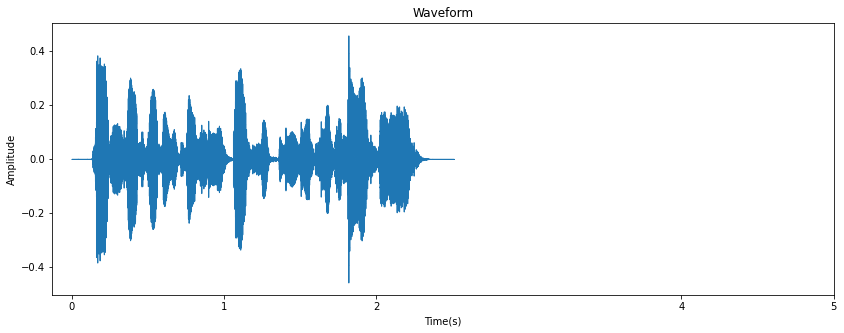

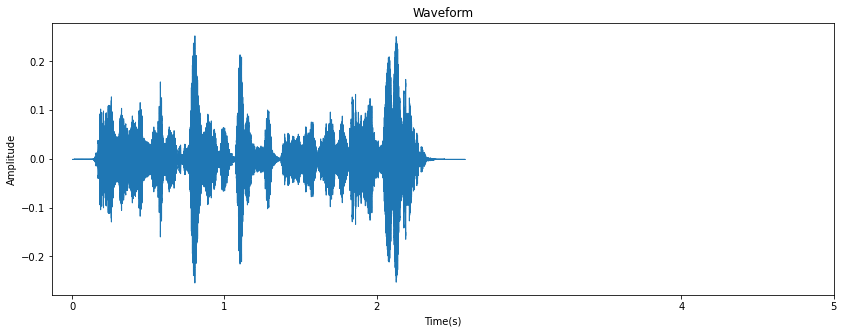

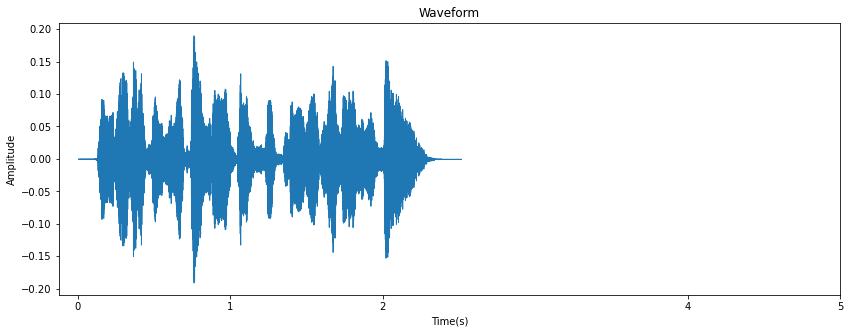

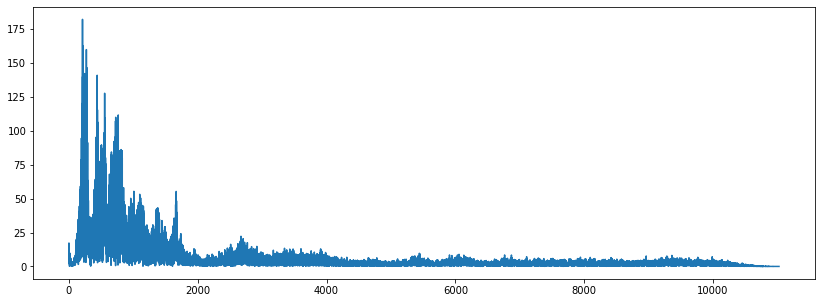

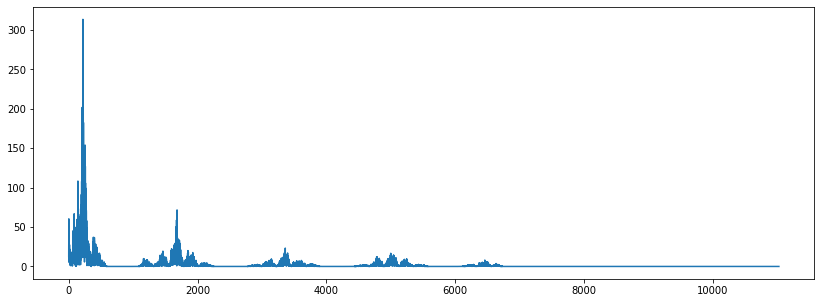

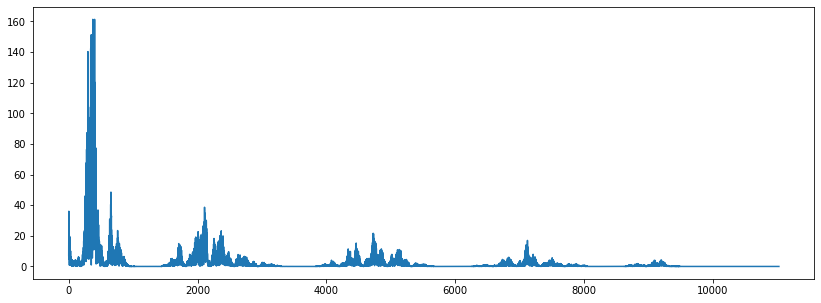

In [ ]:
N = 1024 # segment size for sampling rate 44100 Hz
H_a = int(N*0.5) # analysis hop size between 0.5 ~ 1
hfilt = np.hanning(N) # filter type

# input 
data, sr = librosa.load('/content/drive/MyDrive/colabbox/남자목소리(허튼짓).wav', sr=None)
f0, voiced_flag, voiced_probs = librosa.pyin(data,
                                             fmin=librosa.note_to_hz('C2'),
                                             fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0)
ipd.display(ipd.Audio(data, rate=sr, normalize=False))

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(data, sr=sr)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.xticks([0, 1, 2, 4, 5])
plt.title("Waveform")
plt.show()

alpha_05 = 0.5 # pitch
alpha_15 = 1.5 # pitch

# pitch increase (alpha_05)
data_05 = synthesize_pitch(data, sr, N, H_a, hfilt, alpha=alpha_05)

# frequency stretching
S1_05 = librosa.stft(data_05, n_fft=512, hop_length=64)
S2_05 = warp_spectrum(S1_05, alpha_05**(1/3))
data_05 = librosa.istft(S2_05, hop_length=64, win_length=512)

ipd.display(ipd.Audio(data_05, rate=sr, normalize=True))

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(data_05, sr=sr)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.xticks([0, 1, 2, 4, 5])
plt.title("Waveform")
plt.show()


# pitch increase (alpha_15)
data_15 = synthesize_pitch(data, sr, N, H_a, hfilt, alpha=alpha_15)

# frequency stretching
S1_15 = librosa.stft(data_15, n_fft=512, hop_length=64)
S2_15 = warp_spectrum(S1_15, alpha_15**(1/3))
data_15 = librosa.istft(S2_15, hop_length=64, win_length=512)

ipd.display(ipd.Audio(data_15, rate=sr, normalize=True))

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(data_15, sr=sr)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.xticks([0, 1, 2, 4, 5])
plt.title("Waveform")
plt.show()

#FFT(Fast Fourier Transform) (원본)
fft = np.fft.fft(data)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

fig = plt.figure(figsize = FIG_SIZE)
plt.plot(left_frequency, left_magnitude)

#FFT(Fast Fourier Transform) (0.5배 pitch)
fft1 = np.fft.fft(data_05)

magnitude = np.abs(fft1)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

fig = plt.figure(figsize = FIG_SIZE)
plt.plot(left_frequency, left_magnitude)

#FFT(Fast Fourier Transform) (1.5배 pitch)
fft2 = np.fft.fft(data_15)

magnitude = np.abs(fft2)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

fig = plt.figure(figsize = FIG_SIZE)
plt.plot(left_frequency, left_magnitude)


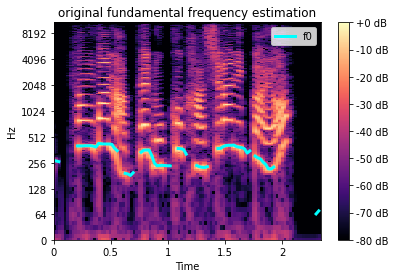

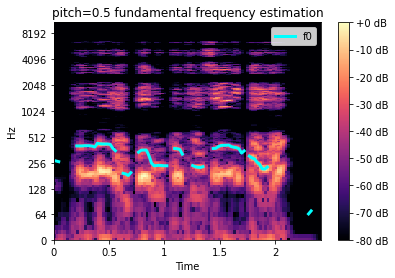

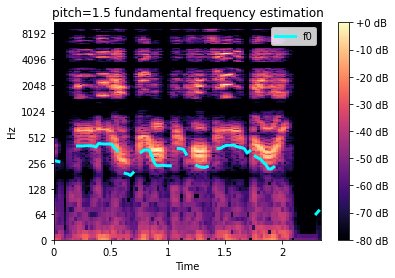

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#원본
D = librosa.amplitude_to_db(np.abs(librosa.stft(data)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='original fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

#0.5배
D = librosa.amplitude_to_db(np.abs(librosa.stft(data_05)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pitch=0.5 fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

#1.5배
D = librosa.amplitude_to_db(np.abs(librosa.stft(data_15)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', ax=ax)
ax.set(title='pitch=1.5 fundamental frequency estimation')
fig.colorbar(img, ax=ax, format="%+2.f dB")
ax.plot(times, f0, label='f0', color='cyan', linewidth=3)
ax.legend(loc='upper right')

**푸리에변환**

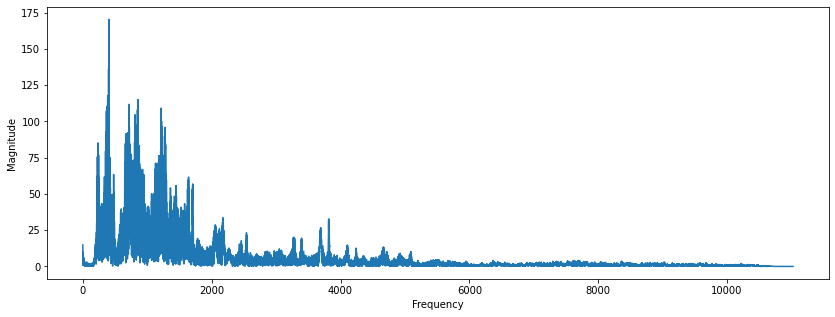

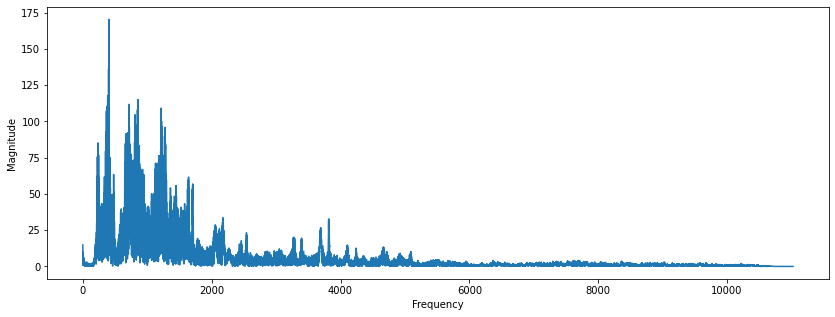

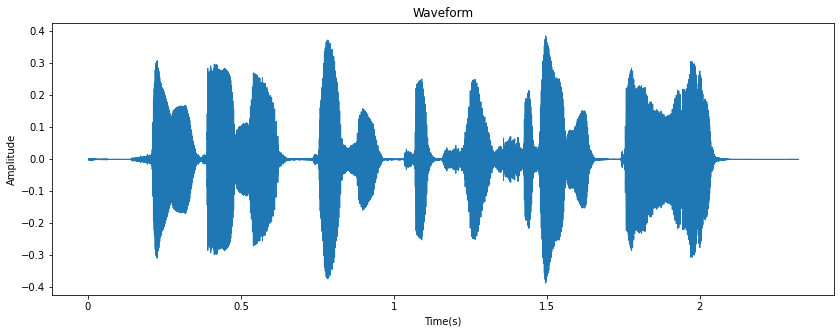

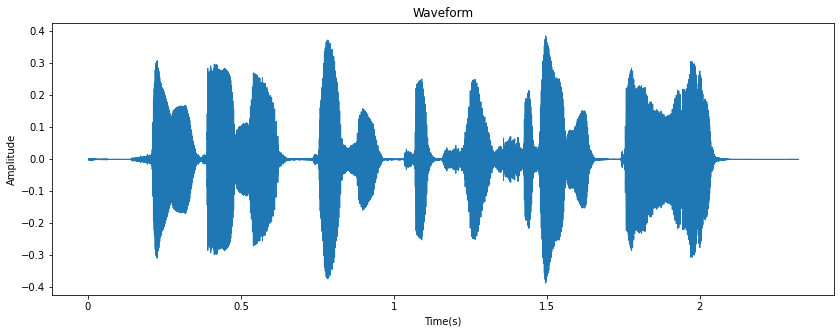

In [ ]:
import librosa, librosa.display
import numpy as np
import matplotlib.pyplot as plt

FIG_SIZE = (14, 5) #그래프 사이즈
audio_path = '/content/drive/MyDrive/colabbox/여자목소리(현관).wav'
y, sr = librosa.load(audio_path)

#FFT(Fast Fourier Transform)
fft1 = np.fft.fft(y)

magnitude = np.abs(fft1)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

fig = plt.figure(figsize = FIG_SIZE)
plt.plot(left_frequency, left_magnitude)
#plt.plot(frequency, magnitude) #대칭 푸리에

plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

#FFT(Fast Fourier Transform)
fft2 = np.fft.fft(data)

magnitude = np.abs(fft2)
frequency = np.linspace(0, sr, len(magnitude))

left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(magnitude)/2)]

fig = plt.figure(figsize = FIG_SIZE)
plt.plot(left_frequency, left_magnitude)
#plt.plot(frequency, magnitude) #대칭 푸리에

plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()


# #STFT(Short-Time Fourier Transform)
# n_fft = 2048
# hop_length = 512

# stft = librosa.stft(y, n_fft = n_fft, hop_length = hop_length)
# spectrogram = np.abs(stft)
# print("Spectogram :\n", spectrogram)

# fig = plt.figure(figsize = FIG_SIZE)
# librosa.display.specshow(spectrogram, sr=sr, hop_length=hop_length)
# plt.xlabel("Time")
# plt.ylabel("Frequency")
# plt.plasma()
# plt.show()


#예제
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(y, sr=sr)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(data, sr=sr)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

# a = [1, 2, 3, 4, 5, 6, 7]
# print(a)
# plt.plot(a)
# plt.show()